In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T  # Transpose to get the shape [2, num_edges]

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)

    return node_features, edge_index, labels


In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

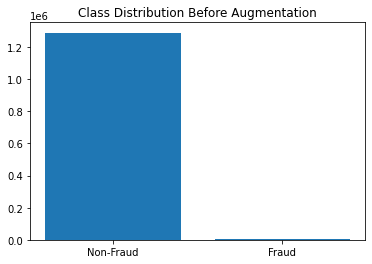

In [8]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
# add GCN Layer

In [10]:
# Define WGAN Generator and Discriminator
class WGANGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WGANGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return self.fc2(z)

In [11]:
class WGANDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WGANDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
# WGAN parameters
input_size = node_features.shape[1]
hidden_size = 128
output_size = input_size
latent_size = 64

In [13]:
# Initialize WGAN components
generator = WGANGenerator(latent_size, hidden_size, output_size)
discriminator = WGANDiscriminator(input_size, hidden_size)

In [14]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [15]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [16]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01])


In [17]:
# Training with early stopping
num_epochs = 16
target_minority_class = torch.sum(labels == 0)
real_data = node_features[labels == 1]

In [18]:
# Early stopping parameters
best_loss_d = float('inf')
patience = 1
trigger_times = 0

In [19]:
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Update the discriminator 5 times for every generator update
    for _ in range(5):
        z = torch.randn(real_data.size(0), latent_size)
        fake_data = generator(z)

        optimizer_d.zero_grad()
        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data)
        loss_d = -torch.mean(d_real) + torch.mean(d_fake)
        loss.backward(retain_graph=True)

        optimizer_d.step()

        # Clip weights
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    optimizer_g.zero_grad()
    fake_data = generator(torch.randn(real_data.size(0), latent_size))
    loss_g = -torch.mean(discriminator(fake_data))
    loss_g.backward()
    optimizer_g.step()

    # Update labels based on newly generated samples
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    node_features = torch.cat((node_features, fake_data))

    # Early stopping check
    if loss_d.item() < best_loss_d:
        best_loss_d = loss_d.item()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered")
        break

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')


NameError: name 'loss' is not defined

In [ ]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))
y_generated = torch.ones(num_generated_samples, dtype=torch.long)

In [ ]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

In [ ]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation")

In [ ]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

In [ ]:
# Assuming real_data is your actual node features labeled as fraud (real minority class)
real_data = node_features[labels == 1]  # Take only fraud samples (minority class)

# If generated_data has more samples than real_data, we need to match their size
min_size = min(real_data.size(0), generated_data.size(0))

# Subsample real and generated data to have the same number of rows
real_data_sampled = real_data[:min_size]
generated_data_sampled = generated_data[:min_size]

# Function to compute R-squared
def r_squared(real_data, generated_data):
    ss_res = torch.sum((real_data - generated_data) ** 2, dim=0)  # Residual sum of squares
    ss_tot = torch.sum((real_data - torch.mean(real_data, dim=0)) ** 2, dim=0)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [ ]:
# Compute R-squared between the real and generated data samples
r2_scores = r_squared(real_data_sampled, generated_data_sampled)
print(f"R-squared for each feature: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean()}")

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Function to calculate MCC
def calculate_mcc(y_true, y_pred):
    # Convert PyTorch tensors to NumPy arrays after detaching from the graph
    y_true_np = y_true.detach().cpu().numpy()  # Detach and move to CPU if necessary
    y_pred_np = y_pred.detach().cpu().numpy()  # Detach and move to CPU if necessary

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

    # Convert confusion matrix components to PyTorch tensors
    tp = torch.tensor(tp, dtype=torch.float)
    tn = torch.tensor(tn, dtype=torch.float)
    fp = torch.tensor(fp, dtype=torch.float)
    fn = torch.tensor(fn, dtype=torch.float)

    # Apply MCC formula
    numerator = (tp * tn) - (fp * fn)
    denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    if denominator == 0:
        return 0  # Handle division by zero
    else:
        mcc = numerator / denominator
        return mcc

In [ ]:
# Let's assume you have binary predictions from the discriminator
real_data_labels = labels  # Known 'is_fraud' labels (0 or 1)
generated_labels = torch.round(discriminator(generated_data_sampled))  # Detach here as well

In [ ]:
# Ensure both real and generated labels have the same size
real_data_labels_sampled = real_data_labels[:min_size]

In [ ]:
# Calculate MCC
mcc = calculate_mcc(real_data_labels_sampled, generated_labels)
print(f"Matthews Correlation Coefficient (MCC): {mcc}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Convert PyTorch tensors to NumPy arrays after detaching from the graph
    y_true_np = y_true.detach().cpu().numpy()  # Detach and move to CPU if necessary
    y_pred_np = y_pred.detach().cpu().numpy()  # Detach and move to CPU if necessary
    
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np)
    recall = recall_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np)
    
    return accuracy, precision, recall, f1

# Calculate metrics for the real and generated data labels
accuracy, precision, recall, f1 = calculate_metrics(real_data_labels_sampled, generated_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Split Data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

In [ ]:
# Define Classifier Model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# Training Classifier on Balanced Dataset
classifier = Classifier(input_size, hidden_size)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [ ]:
from sklearn.metrics import accuracy_score
import torch

# Classifier Training Loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(30):
    # Training phase
    classifier.train()
    optimizer.zero_grad()
    
    # Forward pass and backpropagation
    y_pred = classifier(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Detach loss for recording and release computation graph
    train_losses.append(loss.item())
    
    # Switch to evaluation mode for accuracy calculation
    classifier.eval()
    with torch.no_grad():
        # Training accuracy
        y_pred_train = classifier(x_train)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), y_pred_train.argmax(dim=1).cpu().numpy())
        train_accuracies.append(train_accuracy)
        
        # Testing loss and accuracy
        y_test_pred = classifier(x_test)
        test_loss = loss_fn(y_test_pred, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred.argmax(dim=1).cpu().numpy())
        test_accuracies.append(test_accuracy)
    
    # Print stats every 5 epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')


In [ ]:
# Plot Train-Test Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train-Test Accuracy Curve")
plt.show()

In [ ]:
# Plot Train-Test Loss Curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train-Test Loss Curve")
plt.show()

In [ ]:
# Compute Confusion Matrix and ROC-AUC
y_test_pred = classifier(x_test).argmax(dim=1)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

In [ ]:
# Compute ROC AUC Score
with torch.no_grad():  # Ensure gradients are not being tracked
    y_test_proba = torch.softmax(classifier(x_test), dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_test.numpy(), y_test_proba)
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_test_proba)


In [ ]:
# Plot ROC AUC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC AUC Curve")
plt.show()